# Elo Merchant Category Recommendation
[Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation)

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

## 3. kernel by Robin Denz
[A Closer Look at Date Variables](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)

In [1]:
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import time
from dateutil.relativedelta import relativedelta

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(rc={'figure.figsize': (15, 5)})

In [2]:
train = pd.read_csv('input/train.csv', sep = ',')
test = pd.read_csv('input/test.csv', sep = ',')
merchants = pd.read_csv('input/merchants.csv', sep = ',')
new_merchant = pd.read_csv('input/new_merchant_transactions.csv', sep = ',')

In [3]:
dropping = ['merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']
for var in dropping:
    merchants = merchants.drop(var, axis = 1)

data = pd.merge(merchants, new_merchant, on = 'merchant_id')
data = pd.merge(data, train, on = 'card_id')

In [10]:
print(len(data['first_active_month'].unique()))
sorted = data['first_active_month'].unique()
sorted.sort()
sorted[:10]

74


array(['2011-11', '2011-12', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-07', '2012-08', '2012-09'], dtype=object)

In [11]:
print(len(data['purchase_date'].unique()))
data['purchase_date'][:5]

1082077


0    2018-04-11 11:45:08
1    2018-03-26 15:40:28
2    2018-04-20 20:43:36
3    2018-03-26 14:01:49
4    2018-03-31 07:55:33
Name: purchase_date, dtype: object

In [12]:
data['purchase_time'] = data['purchase_date'].str.split(' ')
data['purchase_date'] = data['purchase_time'].str[0]
data['purchase_time'] = data['purchase_time'].str[1]

In [13]:
def dates_to_numeric(series, kind = 'month'):
    # get all unique values
    months = list(series.unique())

    # sort them
    if kind == 'month':
        date_string = "%Y-%m"
    elif kind == 'day':
        date_string = "%Y-%m-%d"

    # make them a datetime object
    dates = [datetime.datetime.strptime(ts, date_string) for ts in months]
    dates.sort()
    sorteddates = [datetime.datetime.strftime(ts, date_string) for ts in dates]

    # generate all month stamps between first and last
    start_date = sorteddates[0]
    end_date = sorteddates[len(sorteddates) - 1]
    
    cur_date = start = datetime.datetime.strptime(start_date, date_string).date()
    end = datetime.datetime.strptime(end_date, date_string).date()

    months = []
    while cur_date < end:
        if kind == 'month':
            months.append(str(cur_date)[:-3])
            cur_date += relativedelta(months = 1)
        elif kind == 'day':
            months.append(str(cur_date))
            cur_date += relativedelta(days = 1)
    
    # create dict that maps new values to each month
    map_dict = {}
    keys = range(0, len(months))
    for i in keys:
        map_dict[i] = months[i]

    # reverse dict keys / values for mapping
    new_dict = {v: k for k, v in map_dict.items()}
    return new_dict

new_dict = dates_to_numeric(data['first_active_month'])
data['first_active_month_numeric'] = data['first_active_month'].apply(lambda x: new_dict.get(x))

new_dict = dates_to_numeric(data['purchase_date'], kind = 'day')
data['purchase_date_numeric'] = data['purchase_date'].apply(lambda x: new_dict.get(x))

# recode timestamp to number of seconds passed since 00:00:00
def timestamp_to_seconds(time):
    seconds = sum(x * int(t) for x, t in zip([3600, 60, 1], time.split(':'))) 
    return seconds

data['purchase_seconds'] = data['purchase_time'].apply(lambda x: timestamp_to_seconds(x))

Text(0.5,0,'first active month linear')

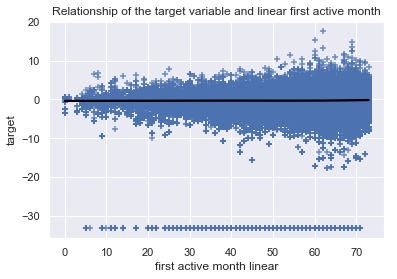

In [14]:
ax = sns.regplot(x = data['first_active_month_numeric'], y = data['target'], marker = "+", lowess = True, line_kws = {'color': 'black'})
ax.set_title('Relationship of the target variable and linear first active month')
ax.set_xlabel('first active month linear')

Text(0.5,0,'purchase date linear')

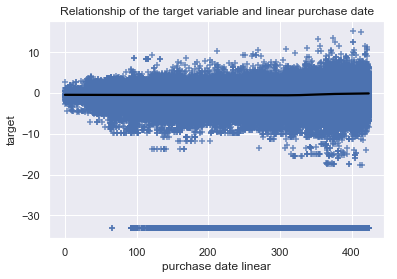

In [15]:
ax = sns.regplot(x = data['purchase_date_numeric'], y = data['target'], marker = "+",
                 lowess = True, line_kws = {'color': 'black'})
ax.set_title('Relationship of the target variable and linear purchase date')
ax.set_xlabel('purchase date linear')

In [16]:
def get_weekday(date_string):
    date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return calendar.day_name[date.weekday()]

# get weekday for date variable
data['purchase_weekday'] = data['purchase_date'].apply(lambda x: get_weekday(x))

# for plotting recode to ordered categorical
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['purchase_weekday'] = pd.Categorical(data['purchase_weekday'], categories = day_labels, 
                                          ordered = True)

def get_month(date_string, kind = 'month'):
    if kind == 'month':
        date = datetime.datetime.strptime(date_string, '%Y-%m')
    elif kind == 'day':
        date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return date.strftime("%B")

data['purchase_month'] = data['purchase_date'].apply(lambda x: get_month(x, kind = 'day'))
data['first_active_month2'] = data['first_active_month'].apply(lambda x: get_month(x))
data['first_active_year'] = data['first_active_month'].str[:4]

month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']
data['purchase_month'] = pd.Categorical(data['purchase_month'], categories = month_labels, 
                                          ordered = True)
data['first_active_month2'] = pd.Categorical(data['first_active_month2'], categories = month_labels, 
                                          ordered = True)

year_labels = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
data['first_active_year'] = pd.Categorical(data['first_active_year'], categories = year_labels, 
                                          ordered = True)

# get time of the day
data['temp'] = data['purchase_time'].str.split(':')

def get_session(time_list):
    time_list[0] = int(time_list[0])
    if time_list[0] > 4 and time_list[0] < 12:
        return 'Morning'
    elif time_list[0] >= 12 and time_list[0] < 17:
        return 'Afternoon'
    elif time_list[0] >= 17 and time_list[0] < 21:
        return 'Evening'
    else:
        return 'Night'
    
data['purchase_session'] = data['temp'].apply(lambda x: get_session(x))

session_labels = ['Morning', 'Afternoon', 'Evening', 'Night']
data['purchase_session'] = pd.Categorical(data['purchase_session'], categories = session_labels, 
                                          ordered = True)

In [17]:
def get_time_of_month_cat(date):
    date_temp = date.split('-')
    if int(date_temp[2]) < 10:
        time_of_month = 'Beginning'
    elif int(date_temp[2]) >= 10 and int(date_temp[2]) < 20:
        time_of_month = 'Middle'
    else:
        time_of_month = 'End'
    return time_of_month

data['time_of_month_cat'] = data['purchase_date'].apply(lambda x: get_time_of_month_cat(x))

tof_labels = ['Beginning', 'Middle', 'End']
data['time_of_month_cat'] = pd.Categorical(data['time_of_month_cat'], categories = tof_labels, 
                                           ordered = True)

data['time_of_month_num'] = data['purchase_date'].str[8:].astype(int)

[Aggregation and representing uncertainty](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty)
The default behavior in seaborn is to aggregate the multiple measurements at each x value by plotting the mean and the 95% confidence interval around the mean.

Text(0.5,0,'Purchase Weekday')

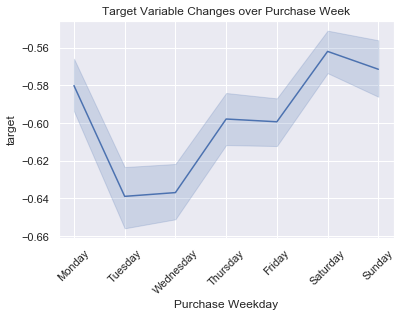

In [21]:
ax = sns.lineplot(x = "purchase_weekday", y = "target", markers = False, dashes = True, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Week')
ax.set_xlabel('Purchase Weekday')

Text(0.5,0,'Purchase Weekday')

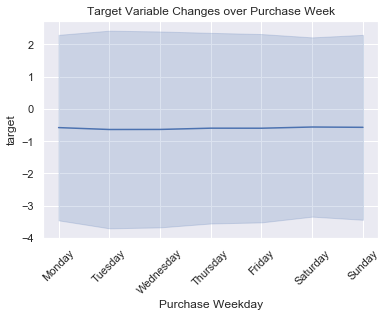

In [22]:
ax = sns.lineplot(x = "purchase_weekday", y = "target", markers = True, dashes = False, data = data, ci="sd")
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Week')
ax.set_xlabel('Purchase Weekday')

Text(0.5,0,'Purchase Month')

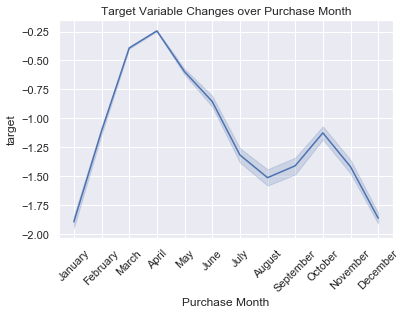

In [23]:
ax = sns.lineplot(x = "purchase_month", y = "target", 
                  markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Month')
ax.set_xlabel('Purchase Month')

Text(0.5,0,'First Active Month')

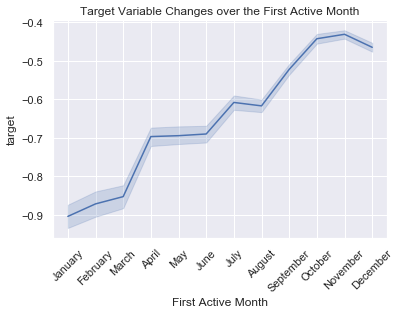

In [24]:
ax = sns.lineplot(x = "first_active_month2", y = "target", 
                  markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Month')
ax.set_xlabel('First Active Month')

Text(0.5,0,'First Active Year')

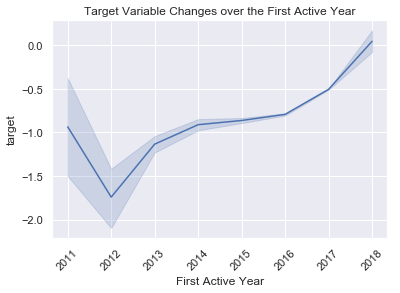

In [25]:
ax = sns.lineplot(x = "first_active_year", y = "target", 
                  markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Year')
ax.set_xlabel('First Active Year')

Text(0.5,0,'Purchase Time of Day')

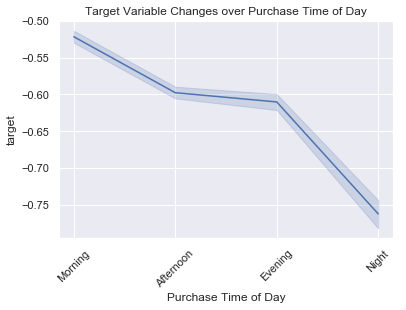

In [26]:
ax = sns.lineplot(x = "purchase_session", y = "target", 
                  markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Time of Day')
ax.set_xlabel('Purchase Time of Day')

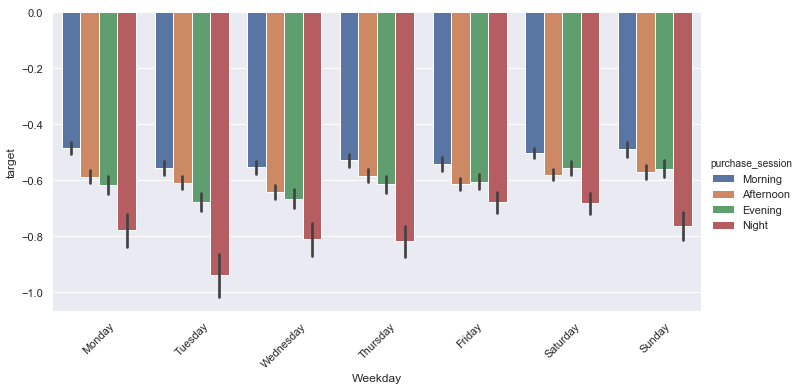

In [27]:
ax = sns.catplot(x = 'purchase_weekday', y = 'target', hue = 'purchase_session', data = data,
                kind = 'bar', height = 5, aspect = 2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("target")
ax.set_xlabels('Weekday')

Text(0.5,0,'time of purchase inside month')

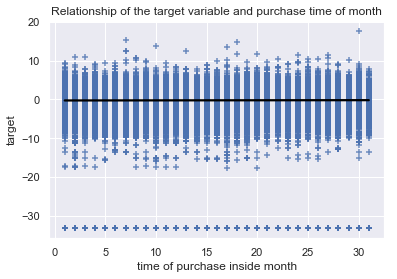

In [28]:
ax = sns.regplot(x = data['time_of_month_num'], y = data['target'], marker = "+",
                 lowess = True, line_kws = {'color': 'black'})
ax.set_title('Relationship of the target variable and purchase time of month')
ax.set_xlabel('time of purchase inside month')

Text(0.5,0,'Purchase Time of Month')

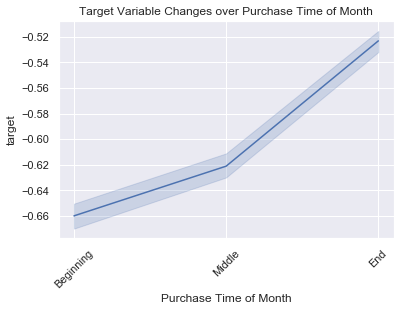

In [29]:
ax = sns.lineplot(x = "time_of_month_cat", y = "target", 
                  markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Time of Month')
ax.set_xlabel('Purchase Time of Month')

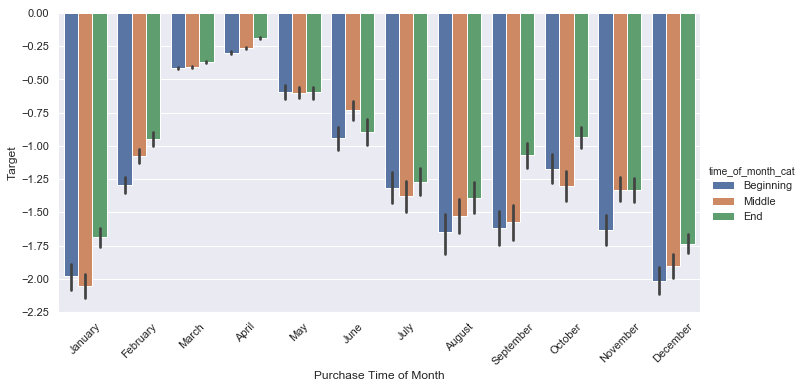

In [30]:
ax = sns.catplot(x = 'purchase_month', y = 'target', hue = 'time_of_month_cat', data = data,
                kind = 'bar', height = 5, aspect = 2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("Target")
ax.set_xlabels('Purchase Time of Month')

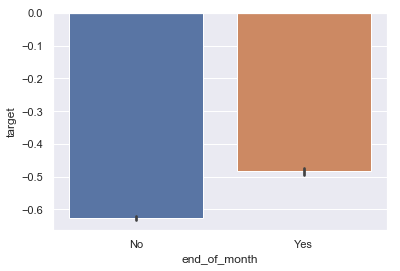

In [31]:
def get_end_of_month(date):
    date_temp = date.split('-')
    if int(date_temp[2]) >= 25:
        end_of_month = 'Yes'
    else:
        end_of_month = 'No'
    return end_of_month

data['end_of_month'] = data['purchase_date'].apply(lambda x: get_end_of_month(x))

ax = sns.barplot(x = 'end_of_month', y = 'target', data = data)